# Getting Started Notebook for Fake News Detection Challenge 


## Download the files 💾

### Downlad AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.

In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

### Login to AIcrowd ㊗

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/1dH-wCxdoiMZ2CY3ZOaYCKzxcvdJFGwNiIMr2atxcRk


### Download Dataset and Unzip

We will create a folder name `data` and download and unzip the files there.

In [ ]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c fake-news-detection -o data

train.zip:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/580k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/5.56M [00:00<?, ?B/s]

In [ ]:
!unzip data/train -d data/train > /dev/null
!unzip data/test -d data/test > /dev/null
!unzip data/val -d data/val > /dev/null

# Generating Random Submission ⚙️

Making a submission with random predictions. We will randomly select 'real' and 'fake' for the news article.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import nltk

import time
from tqdm.notebook import tqdm

sns.set()

In [ ]:
# Reading the testing  dataset

df_train = pd.read_csv(os.path.join("data", "train", "train.csv"))
df_val = pd.read_csv(os.path.join("data", "val", "val.csv"))
df_test = pd.read_csv(os.path.join("data", "test", "test.csv"))

In [ ]:
df_train['label'] = df_train['label'].map({"real" : 1 , "fake" : 0})
df_train['label'].value_counts()

1    164751
0     67252
Name: label, dtype: int64

In [ ]:
# Declaring the function

import re

def process_text(text):

    # Lowercasing
    text = text.lower()

    # Replacing all the urls
    text = re.sub('(?i)\\b((?:https?://|www\\d{0,3}[.]|[a-z0-9.\\-]+[.][a-z]{2,4}/)(?:[^\\s()<>]+|\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\))+(?:\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\)|[^\\s`!()\\[\\]{};:\'\\".,<>?\xc2\xab\xc2\xbb\xe2\x80\x9c\xe2\x80\x9d\xe2\x80\x98\xe2\x80\x99]))'
               , '', text)

    # Replacing all user tags
    text = re.sub(r"@[^\s]+", '', text)

    # Replacing all hashtags
    text = re.sub(r"#[^\s]+", '', text)

    # Remove some punctuations
    text = re.sub(r"[!?,'\"*)@#%(&$_.^-]", '', text)

    # Splitting on spaces
    text = text.split(' ')

    # Stemming and removing spaces
    stemmer_ps = nltk.stem.PorterStemmer()  
    text = [stemmer_ps.stem(word) for word in text if len(word)]

    return text

In [ ]:
# Modifying the data on the entire dataset
# Takes 280 secs

start = time.time()

df_train['text'] = df_train['text'].map(process_text)

end = time.time()
print(end - start)

278.8981866836548


In [ ]:
from sklearn.model_selection import train_test_split

Train, Val = train_test_split(df_train , stratify = df_train["label"], test_size=0.02)

Train = Train.to_numpy()
Val = Val.to_numpy()

del df_train

In [ ]:
# Creating the word frequency dictionary to remove very rare words.

wordfreq = {}

start = time.time()

for text , _ in tqdm(Train):
  for w in text:
    if w not in wordfreq:
      wordfreq[w] = 1
    else:
      wordfreq[w] += 1

end = time.time()
print(end - start)

  0%|          | 0/227362 [00:00<?, ?it/s]

7.299870729446411


In [ ]:
# Getting words that have occured more than 100 times in tweets

words = [word for word in wordfreq if wordfreq[word] <= 100]
low_words = len(words)
total_words = len(wordfreq)
print(low_words , total_words - low_words , (low_words / total_words * 100) , ((total_words - low_words) / total_words * 100))

191782 6218 96.85959595959595 3.1404040404040408


In [ ]:
# Removing the low occurence words from the wordfreq dictionaries

for word in tqdm(words):
  if word in wordfreq: 
    del wordfreq[word]

  0%|          | 0/191782 [00:00<?, ?it/s]

In [ ]:
# Removing the low occurence words from the tweets

start = time.time()

for i in tqdm(range(len(Train))):
  Train[i][0] = [ word for word in Train[i][0] if word in wordfreq]

end = time.time()
print(end - start)

  0%|          | 0/227362 [00:00<?, ?it/s]

4.312155723571777


In [ ]:
# Creating the word to number dictionary for the embedding layer

word2idx = {}

start = time.time()

for text , _ in tqdm(Train):
  for w in text:
    if w not in word2idx:
        word2idx[w] = (len(word2idx) + 1)

end = time.time()
print(end - start)

  0%|          | 0/227362 [00:00<?, ?it/s]

3.5042595863342285


In [ ]:
# Converting the tweet's words to numbers

start = time.time()

for i in tqdm(range(len(Train))):
  Train[i][0] = [ word2idx[word] for word in Train[i][0] if word in word2idx]

end = time.time()
print(end - start)

  0%|          | 0/227362 [00:00<?, ?it/s]

5.571214437484741


In [ ]:
# Creating the feature variable and padding them
X = tf.keras.preprocessing.sequence.pad_sequences(Train[ : , 0] , padding = 'post')


# Creating the target variable
Y = Train[ : , 1]

MAX_LEN = len(X[1])

In [ ]:
# Preprocessing the Validation Split

for i in tqdm(range(len(Val))):
  Val[i][0] = data = [ word2idx[word] for word in Val[i][0] if word in word2idx]

X_val = tf.keras.preprocessing.sequence.pad_sequences(Val[ : , 0] , padding = 'post' , maxlen = MAX_LEN)
Y_val = Val[ : , 1]

  0%|          | 0/4641 [00:00<?, ?it/s]

In [ ]:
INPUT_DIM = len(X)
OUTPUT_DIM = 5
INPUT_LEN = len(X[0])
BATCH_SIZE = 1024

model = keras.Sequential()

model.add(layers.Embedding(input_dim=INPUT_DIM + 1 , output_dim=OUTPUT_DIM , input_length=INPUT_LEN ))
model.add(layers.LSTM(64))
model.add(layers.Dense(64 , activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32 , activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 97, 5)             1136815   
                                                                 
 lstm_2 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,161,008
Trainable params: 1,161,008
No

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/weights/',save_weights_only=True)

# Converting for Tensorflow Compatibility
Y = Y.astype('float64')
Y_val = Y_val.astype('float64')

# Compiling the model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

# Fitting the model
history = model.fit(X, Y, batch_size=BATCH_SIZE, epochs=15, validation_data = (X_val , Y_val) , callbacks=[cp_callback])

Epoch 1/15
222/223 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8372
Epoch 00001: saving model to /content/weights/
223/223 [==============================] - 11s 41ms/step - loss: 0.3683 - accuracy: 0.8373 - val_loss: 0.1887 - val_accuracy: 0.9267
Epoch 2/15
223/223 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9407
Epoch 00002: saving model to /content/weights/
223/223 [==============================] - 8s 37ms/step - loss: 0.1567 - accuracy: 0.9407 - val_loss: 0.1545 - val_accuracy: 0.9433
Epoch 3/15
223/223 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9488
Epoch 00003: saving model to /content/weights/
223/223 [==============================] - 8s 37ms/step - loss: 0.1373 - accuracy: 0.9488 - val_loss: 0.1644 - val_accuracy: 0.9369
Epoch 4/15
223/223 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9503
Epoch 00004: saving model to /content/weights/
223/223 [======================

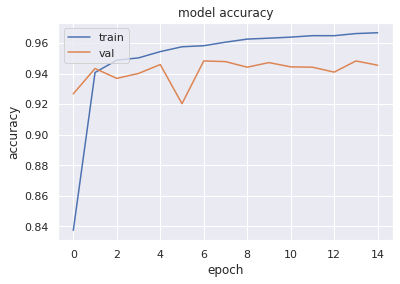

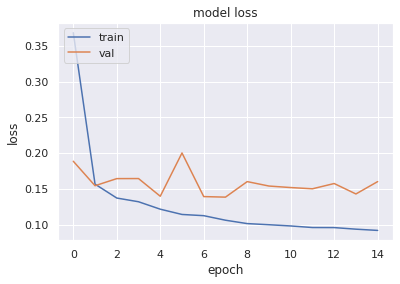

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Preprocessing the Test Dataset

start = time.time()

df_val['label'] = df_val['label'].map({"real" : 1 , "fake" : 0})
df_val['text'] = df_val['text'].map(process_text)

end = time.time()
print(end - start)

Test = df_val.to_numpy()

for i in tqdm(range(len(Test))):
  Test[i][0] = data = [ word2idx[word] for word in Test[i][0] if word in word2idx]

# Splitting the Test set and padding the features

X_test = tf.keras.preprocessing.sequence.pad_sequences(Test[ : , 0] , padding = 'post' , maxlen = MAX_LEN)
Y_test = Test[ : , 1]

47.1826593875885


  0%|          | 0/38666 [00:00<?, ?it/s]

In [ ]:
# Predicting
Y_pred = model.predict(X_test)

# As the outputs are probabilities they are converted to Binary Outcome ( There is probably a cleaner way to do this)
Y_pred = np.where(Y_pred > 0.5, 1, 0)
Y_test = list(Y_test)

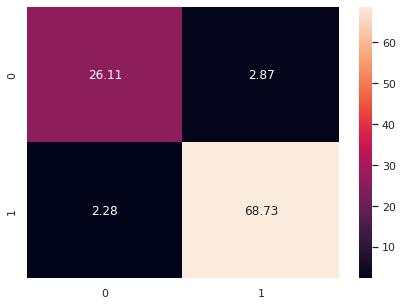

In [ ]:
# Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix
df_cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize = (7,5))
sns.heatmap(df_cm / len(Y_test) * 100, fmt = '.2f', annot=True)

In [ ]:
# Metrics related to the classification
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11208
           1       0.96      0.97      0.96     27458

    accuracy                           0.95     38666
   macro avg       0.94      0.93      0.94     38666
weighted avg       0.95      0.95      0.95     38666



In [ ]:
Test_raw = df_test.to_numpy()
Test = []

In [ ]:
for line in Test_raw:
  line = process_text(line[0])
  line = [word2idx[word] for word in line if word in word2idx]
  Test.append(line)

In [ ]:
Test = tf.keras.preprocessing.sequence.pad_sequences(Test , padding = 'post' , maxlen = MAX_LEN)

In [ ]:
Y_final = model.predict(Test)

In [ ]:
# As the outputs are probabilities they are converted to Binary Outcome ( There is probably a cleaner way to do this)
Y_final = np.where(Y_final > 0.5, 1, 0)
Y_final = list(Y_final)

In [ ]:
for i in range(len(Y_final)):
  Y_final[i] = "fake" if list(Y_final[i])[0] == 0 else "real"

In [ ]:
df_test['label'] = Y_final
df_test = df_test.drop(columns=['text'])

In [ ]:
df_test.to_csv('subimssion_fake.csv', index=False)